In [1]:
import requests
import datetime
import time
import csv
import os
import pandas as pd
import numpy as np
from typing import List, Dict
from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
import seaborn as sns

import folium
from folium.plugins import HeatMap

from sklearn.cluster import DBSCAN

Mounted at /content/drive


**What This project Produces:**

✔ Clean, defensible dataset

✔ Daily trend analysis

✔ Geographic hotspots

✔ Equipment & model vulnerability

✔ Statistically detected combat clusters

✔ Analyst-ready metrics for reporting

In [2]:

# === CONFIGURATION ===
BELLIGERENT = "russia"
BASE_URL = "https://ukr.warspotting.net/api"
HEADERS = {"User-Agent": "WarSpotClient/1.0 (contact@example.com)"}
SLEEP_BETWEEN_DATES = 2
CSV_FILE = "warspotting_losses.csv"

In [3]:
# === MODE DECISION ===
TODAY = datetime.date.today()
IS_SUNDAY = TODAY.weekday() == 6
IS_FULL_SCAN = IS_SUNDAY

In [4]:

# === DATE RANGE ===
if IS_FULL_SCAN:
    START_DATE = datetime.date(2022, 2, 24)
    END_DATE = TODAY
else:
    START_DATE = TODAY - datetime.timedelta(days=30)
    END_DATE = TODAY

In [5]:

# === FETCHING FUNCTION ===
def fetch_day_all_pages(date_str: str, belligerent: str) -> List[Dict]:
    all_losses = []
    page = 1
    while True:
        url = f"{BASE_URL}/losses/{belligerent}/{date_str}/{page}/" if page > 1 else f"{BASE_URL}/losses/{belligerent}/{date_str}/"
        print(f"    → Fetching: {url}")
        try:
            r = requests.get(url, headers=HEADERS, timeout=30)
            if r.status_code == 404:
                print(f"    No data for {date_str} page {page} (404).")
                break
            r.raise_for_status()
            losses = r.json().get("losses", [])
            if not losses:
                break
            all_losses.extend(losses)
            if len(losses) < 100:
                break  # Last page
            page += 1
        except requests.RequestException as e:
            print(f"    Request error: {e}")
            break
    return all_losses

In [6]:
# === FLATTEN FUNCTION ===
def flatten(e: Dict) -> Dict:
    lat, lon = (None, None)
    if e.get("geo") and "," in e["geo"]:
        parts = e["geo"].split(",")
        if len(parts) == 2:
            lat, lon = parts[0].strip(), parts[1].strip()

    return {
        "id": e.get("id"),
        "date": e.get("date"),
        "type": e.get("type"),
        "model": e.get("model"),
        "status": e.get("status"),
        "lost_by": e.get("lost_by"),
        "nearest_location": e.get("nearest_location"),
        "geo": e.get("geo"),
        "latitude": lat,
        "longitude": lon,
        "unit": e.get("unit"),
        "tags": e.get("tags"),
        "comment": e.get("comment"),
        "sources": ", ".join(e.get("sources", [])) if isinstance(e.get("sources"), list) else e.get("sources"),
        "photos": ", ".join(e.get("photos", [])) if isinstance(e.get("photos"), list) else e.get("photos"),
    }

In [7]:
# === MAIN ===
def main():
    print(f"\n{'='*40}\nRunning {'FULL' if IS_FULL_SCAN else '30-DAY'} SCAN: {START_DATE} to {END_DATE}\n{'='*40}")
    all_data = []
    current = START_DATE

    while current <= END_DATE:
        ds = current.isoformat()
        print(f"📅 Fetching records for {ds} …")
        day_records = fetch_day_all_pages(ds, BELLIGERENT)
        flattened = [flatten(r) for r in day_records]
        all_data.extend(flattened)
        print(f"    ✓ {len(flattened)} records found for {ds}")
        current += datetime.timedelta(days=1)
        time.sleep(SLEEP_BETWEEN_DATES)

    if not all_data:
        print("\n⚠️  No data found.")
        return

    df_new = pd.DataFrame(all_data)

    if IS_FULL_SCAN or not os.path.exists(CSV_FILE):
        df_new.to_csv(CSV_FILE, index=False)
        print(f"\n✅ Wrote {len(df_new)} records to {CSV_FILE}")
    else:
        df_existing = pd.read_csv(CSV_FILE)
        df_combined = pd.concat([df_existing, df_new], ignore_index=True)
        df_combined.drop_duplicates(subset="id", inplace=True)
        df_combined.to_csv(CSV_FILE, index=False)
        print(f"\n✅ Appended {len(df_new)} new, total {len(df_combined)} unique records to {CSV_FILE}")

if __name__ == "__main__":
    main()



Running 30-DAY SCAN: 2025-12-11 to 2026-01-10
📅 Fetching records for 2025-12-11 …
    → Fetching: https://ukr.warspotting.net/api/losses/russia/2025-12-11/
    ✓ 0 records found for 2025-12-11
📅 Fetching records for 2025-12-12 …
    → Fetching: https://ukr.warspotting.net/api/losses/russia/2025-12-12/
    ✓ 3 records found for 2025-12-12
📅 Fetching records for 2025-12-13 …
    → Fetching: https://ukr.warspotting.net/api/losses/russia/2025-12-13/
    ✓ 1 records found for 2025-12-13
📅 Fetching records for 2025-12-14 …
    → Fetching: https://ukr.warspotting.net/api/losses/russia/2025-12-14/
    ✓ 5 records found for 2025-12-14
📅 Fetching records for 2025-12-15 …
    → Fetching: https://ukr.warspotting.net/api/losses/russia/2025-12-15/
    ✓ 3 records found for 2025-12-15
📅 Fetching records for 2025-12-16 …
    → Fetching: https://ukr.warspotting.net/api/losses/russia/2025-12-16/
    ✓ 12 records found for 2025-12-16
📅 Fetching records for 2025-12-17 …
    → Fetching: https://ukr.warspo

In [8]:
path = "/content/warspotting_losses.csv"
df = pd.read_csv(path)
df

,id,date,type,model,status,lost_by,nearest_location,geo,latitude,longitude,unit,tags,comment,sources,photos
0,41676,2025-12-12,Infantry fighting vehicles,BTR-82AT,Destroyed,Russia,"Stepanivka (Illinivka hromada), Kramatorsk raion","48.458191,37.584034",48.458191,37.584034,NaN,Cope cage,NaN,NaN,NaN
1,41679,2025-12-12,Infantry fighting vehicles,BTR-82AT,Destroyed,Russia,"Stepanivka (Illinivka hromada), Kramatorsk raion","48.443208,37.587230",48.443208,37.587230,NaN,"Turretless, Cope cage, Jammer",NaN,NaN,NaN
2,41805,2025-12-12,Transport,ATS-59G artillery tractor,Destroyed,Russia,"Verbove (Pokrovske hromada), Synelnykove raion","47.87560,36.39446",47.875600,36.394460,NaN,"Cope cage, Expanded cabin, Additional armour",NaN,NaN,NaN
3,42065,2025-12-13,Transport,KamAZ 6x6,Destroyed,Russia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,41464,2025-12-14,Anti-aircraft systems,2S6M combat vehicle (for 2K22M 'Tunguska-M'),Destroyed,Russia,"Kakhovka raion, Kherson oblast",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,42071,2026-01-07,Transport,'Ulan' all-terrain vehicle,Destroyed,Russia,"Kherson raion, Kherson oblast",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155,42091,2026-01-07,Infantry fighting vehicles,BMP-1(P),Destroyed,Russia,"Spirne, Bakhmut raion","48.786488,38.225231",48.786488,38.225231,NaN,Turtle,NaN,NaN,NaN
156,42097,2026-01-07,Infantry fighting vehicles,BMP-3,Destroyed,Russia,"Polohy raion, Zaporizhzhia oblast",NaN,NaN,NaN,NaN,Turretless,NaN,NaN,NaN
157,42096,2026-01-08,Infantry fighting vehicles,MT-LB(V),Destroyed,Russia,"Svatove raion, Luhansk oblast",NaN,NaN,NaN,NaN,"Z, Cope cage, ◇",NaN,NaN,NaN


In [ ]:
#df['column_name'] = df['column_name'].fillna(0)

In [9]:
df = df.fillna(0)
df.head()


,id,date,type,model,status,lost_by,nearest_location,geo,latitude,longitude,unit,tags,comment,sources,photos
0,41676,2025-12-12,Infantry fighting vehicles,BTR-82AT,Destroyed,Russia,"Stepanivka (Illinivka hromada), Kramatorsk raion","48.458191,37.584034",48.458191,37.584034,0,Cope cage,0.0,0.0,0.0
1,41679,2025-12-12,Infantry fighting vehicles,BTR-82AT,Destroyed,Russia,"Stepanivka (Illinivka hromada), Kramatorsk raion","48.443208,37.587230",48.443208,37.587230,0,"Turretless, Cope cage, Jammer",0.0,0.0,0.0
2,41805,2025-12-12,Transport,ATS-59G artillery tractor,Destroyed,Russia,"Verbove (Pokrovske hromada), Synelnykove raion","47.87560,36.39446",47.875600,36.394460,0,"Cope cage, Expanded cabin, Additional armour",0.0,0.0,0.0
3,42065,2025-12-13,Transport,KamAZ 6x6,Destroyed,Russia,0,0,0.000000,0.000000,0,0,0.0,0.0,0.0
4,41464,2025-12-14,Anti-aircraft systems,2S6M combat vehicle (for 2K22M 'Tunguska-M'),Destroyed,Russia,"Kakhovka raion, Kherson oblast",0,0.000000,0.000000,0,0,0.0,0.0,0.0


In [22]:
df.to_csv("warspotting_losses_cleaned.csv", index=False)

**Data Cleaning & Normalization**

In [10]:
# Date parsing
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop invalid coordinates
df = df.dropna(subset=['latitude', 'longitude'])
df = df[
    (df['latitude'].between(-90, 90)) &
    (df['longitude'].between(-180, 180))
]

# Normalize text fields
for col in ['type', 'model', 'status', 'lost_by', 'nearest_location', 'geo', 'unit', 'tags']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.lower().str.strip()

# Replace missing categorical values
df[['type','status','lost_by']] = df[['type','status','lost_by']].fillna('unknown')

df.shape



(159, 15)

In [11]:
df


,id,date,type,model,status,lost_by,nearest_location,geo,latitude,longitude,unit,tags,comment,sources,photos
0,41676,2025-12-12,infantry fighting vehicles,btr-82at,destroyed,russia,"stepanivka (illinivka hromada), kramatorsk raion","48.458191,37.584034",48.458191,37.584034,0,cope cage,0.0,0.0,0.0
1,41679,2025-12-12,infantry fighting vehicles,btr-82at,destroyed,russia,"stepanivka (illinivka hromada), kramatorsk raion","48.443208,37.587230",48.443208,37.587230,0,"turretless, cope cage, jammer",0.0,0.0,0.0
2,41805,2025-12-12,transport,ats-59g artillery tractor,destroyed,russia,"verbove (pokrovske hromada), synelnykove raion","47.87560,36.39446",47.875600,36.394460,0,"cope cage, expanded cabin, additional armour",0.0,0.0,0.0
3,42065,2025-12-13,transport,kamaz 6x6,destroyed,russia,0,0,0.000000,0.000000,0,0,0.0,0.0,0.0
4,41464,2025-12-14,anti-aircraft systems,2s6m combat vehicle (for 2k22m 'tunguska-m'),destroyed,russia,"kakhovka raion, kherson oblast",0,0.000000,0.000000,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,42071,2026-01-07,transport,'ulan' all-terrain vehicle,destroyed,russia,"kherson raion, kherson oblast",0,0.000000,0.000000,0,0,0.0,0.0,0.0
155,42091,2026-01-07,infantry fighting vehicles,bmp-1(p),destroyed,russia,"spirne, bakhmut raion","48.786488,38.225231",48.786488,38.225231,0,turtle,0.0,0.0,0.0
156,42097,2026-01-07,infantry fighting vehicles,bmp-3,destroyed,russia,"polohy raion, zaporizhzhia oblast",0,0.000000,0.000000,0,turretless,0.0,0.0,0.0
157,42096,2026-01-08,infantry fighting vehicles,mt-lb(v),destroyed,russia,"svatove raion, luhansk oblast",0,0.000000,0.000000,0,"z, cope cage, ◇",0.0,0.0,0.0


**Filter to Last 30 Days**

In [12]:
end_date = df['date'].max()
start_date = end_date - pd.Timedelta(days=30)

df_30 = df[df['date'] >= start_date].copy()

df_30[['date']].describe()


,date
count,159
mean,2025-12-23 07:41:53.207547136
min,2025-12-12 00:00:00
25%,2025-12-19 00:00:00
50%,2025-12-22 00:00:00
75%,2025-12-27 00:00:00
max,2026-01-08 00:00:00


**Descriptive Statistics**:

In [13]:
#Equipment Losses by Type
loss_by_type = df_30['type'].value_counts()
loss_by_type


,count
type,
infantry fighting vehicles,54
transport,38
tanks,31
other,12
anti-aircraft systems,5
drones,5
towed artillery,4
rocket and missile artillery,4
infantry mobility vehicles,2


In [14]:
#Losses by Status
loss_by_status = df_30['status'].value_counts(normalize=True) * 100
loss_by_status

,proportion
status,
destroyed,89.937107
abandoned,5.031447
captured,3.144654
damaged,1.886792


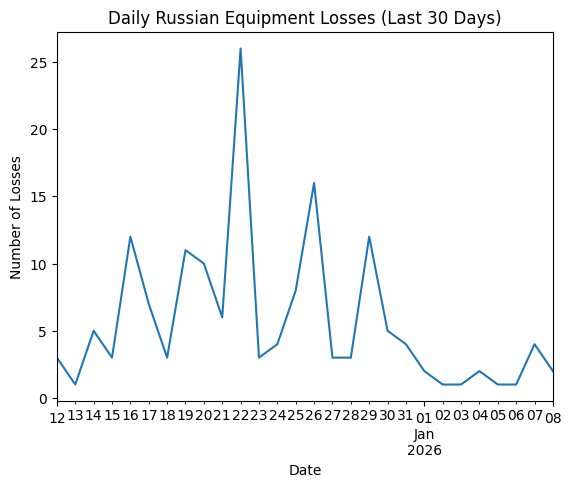

In [15]:
#Daily Loss Trend
daily_losses = df_30.groupby('date').size()

plt.figure()
daily_losses.plot()
plt.title("Daily Russian Equipment Losses (Last 30 Days)")
plt.xlabel("Date")
plt.ylabel("Number of Losses")
plt.show()


In [16]:
#Spatial Grid Aggregation
# Create geographic bins
df_30['lat_bin'] = df_30['latitude'].round(1)
df_30['lon_bin'] = df_30['longitude'].round(1)

grid_losses = (
    df_30
    .groupby(['lat_bin','lon_bin'])
    .size()
    .reset_index(name='losses')
    .sort_values('losses', ascending=False)
)

grid_losses


,lat_bin,lon_bin,losses
0,0.0,0.0,84
13,48.4,37.3,26
6,48.1,36.8,7
15,48.4,37.5,4
14,48.4,37.4,3
12,48.3,37.4,3
7,48.1,36.9,3
23,49.1,37.7,3
5,48.0,36.9,2
8,48.1,37.0,2


In [17]:
#Time Segmentation (Early / Mid / Late)
df_30['period'] = pd.qcut(
    df_30['date'],
    q=3,
    labels=['Early', 'Mid', 'Late']
)

df_30.groupby(['period','type']).size().unstack(fill_value=0)


/tmp/ipython-input-2702086463.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_30.groupby(['period','type']).size().unstack(fill_value=0)


type,anti-aircraft systems,drones,engineering,infantry fighting vehicles,infantry mobility vehicles,other,"radars, jammers",rocket and missile artillery,tanks,towed artillery,transport
period,,,,,,,,,,,
Early,4,2,0,20,0,7,0,0,8,3,11
Mid,1,1,2,26,1,1,0,2,19,1,9
Late,0,2,0,8,1,4,2,2,4,0,18


In [18]:
#Equipment Model Vulnerability
model_losses = (
    df_30
    .groupby(['type','model'])
    .size()
    .sort_values(ascending=False)
)

model_losses.head(60)


type                          model                                                  
infantry fighting vehicles    mt-lb(v)                                                   18
transport                     ural-4320                                                  11
tanks                         unknown t-80 obr. 2022                                      8
transport                     kamaz 6x6                                                   7
infantry fighting vehicles    btr-82at                                                    6
other                         'kuryer' logistics ugv                                      5
transport                     'ulan' all-terrain vehicle                                  5
tanks                         t-62m obr. 2022                                             4
                              t-80bvm obr. 2022                                           4
transport                     'ulan-2' all-terrain vehicle                                4
infantry fighting vehicles    btr-80                                                      4
                              unknown ifv                                                 4
tanks                         unknown t-72 obr. 2022                                      4
towed artillery               122mm 2a18 d-30 howitzer                                    4
transport                     zil-131-based vehicle                                       4
infantry fighting vehicles    bmp-3 688a-sb6-2kp                                          3
                              bmp-1 or -2                                                 3
tanks                         t-72b3 obr. 2022                                            3
other                         'kuryer' armed ugv                                          3
rocket and missile artillery  107mm type 75 towed mrl                                     2
                              122mm 2b17 bm-21-1 (for 9k51 'grad')                        2
infantry mobility vehicles    amn-233114 'tigr-m' with 'arbalet-dm'                       2
infantry fighting vehicles    btr-82a(m)                                                  2
                              bmp-3                                                       2
                              bmp-2m 675-sb3kdz                                           2
drones                        zala z-16 (421-16е) reconnaissance uav                      2
infantry fighting vehicles    bmp-1(p)                                                    2
drones                        'orlan-10' reconnaissance uav                               2
infantry fighting vehicles    btr-80 or -82                                               2
transport                     unknown truck                                               2
tanks                         unknown tank                                                2
                              t-72*                                                       2
infantry fighting vehicles    bmp-1am 675-sb3kdz                                          1
                              bmp-2(k)                                                    1
drones                        skat 350m reconnaissance uav                                1
infantry fighting vehicles    bmp-1am 'basurmanin'                                        1
                              btr-70m                                                     1
anti-aircraft systems         mt-lb(v) with zu-23 aa gun                                  1
                              9a33bm telar (for 9k33m3 'osa-akm')                         1
                              72v6 combat vehicle (for 96k6 'pantsir-s1')                 1
                              5p85sm2-01 tel (for 40r6 s-400 'triumf')                    1
engineering                   brem-1(m) armoured recovery vehicle                         1
infantry fighting vehicles    bmp-1 or -2 675-sb3k

In [19]:
# Status × Geography
status_geo = (
    df_30
    .groupby(['status','lat_bin','lon_bin'])
    .size()
    .reset_index(name='count')
    .sort_values('count', ascending=False)
)

status_geo.head(60)


,status,lat_bin,lon_bin,count
7,destroyed,0.0,0.0,78
19,destroyed,48.4,37.3,21
13,destroyed,48.1,36.8,7
0,abandoned,48.4,37.3,5
3,captured,0.0,0.0,5
21,destroyed,48.4,37.5,4
20,destroyed,48.4,37.4,3
18,destroyed,48.3,37.4,3
1,abandoned,48.5,37.8,2
12,destroyed,48.0,36.9,2


In [20]:
#DBSCAN Spatial Clustering
coords = df_30[['latitude','longitude']].values

dbscan = DBSCAN(
    eps=0.1,       # ~10 km, adjust if needed
    min_samples=8
)

df_30['cluster'] = dbscan.fit_predict(coords)

df_30['cluster'].value_counts()


,count
cluster,
0,84
2,37
-1,27
1,11


In [21]:
#Key Metrics Summary
summary = {
    "Total losses (30 days)": len(df_30),
    "Unique locations": df_30[['lat_bin','lon_bin']].drop_duplicates().shape[0],
    "Equipment types": df_30['type'].nunique(),
    "Active clusters": df_30['cluster'].nunique() - (1 if -1 in df_30['cluster'].values else 0)
}

pd.Series(summary)


,0
Total losses (30 days),159
Unique locations,28
Equipment types,11
Active clusters,3
